# In this jupyter notebook the inference over the generative model will be made

In [1]:
import random
import numpy as np
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt

#minsearch will be used to determine the closest point in the grid later on, effectively making sure that the delta
#functions below are done
def minsearch(x, v):
    return np.where(np.abs(x-v) == np.abs(x-v).min())[0]

For the generative model the reader is refered to the README on the github page (https://github.com/JochemBeurskens/BCI_model_python/blob/main/README.md).

For a common source (C=1):
\begin{equation}
\begin{aligned}
    \ a^x_{L_{av}^{xa},M_{av}^{xa}}(l,t,m) =  \delta(l-L_{av}^{xa}) \delta(m-M_{av}^{xa}) f^s_a(c_{av}^s(t))+e_a(l,t,m)\\ v^x_{L_{av}^{xv},M_{av}^{xv}}(l,t,m) =  \delta(l-L_{av}^{xv}) \delta(m-M_{av}^{xv}) f^s_v(c_{av}^s(t))+e_v(l,t,m) 
\end{aligned}
\end{equation}

with:
$e_a(l,t,m)\sim N(0,\sigma_a^2)$ 
$e_v(l,t,m)\sim N(0,\sigma_v^2)$ 
$L_{av}^{xa} \sim N(L_{av}^s,\sigma_{La}^2)$ 
$L_{av}^{xv} \sim N(L_{av}^s,\sigma_{Lv}^2)$ 
$M_{av}^{xa} \sim N(M_{av}^s,\sigma_{Ma}^2)$ 
$M_{av}^{xv} \sim N(M_{av}^s,\sigma_{Mv}^2)$ 


For separate sources (C=2):
\begin{equation}
\begin{aligned}
     a^{x}_{L_{a}^{x},M_{a}^{x}}(l,t,m) = \delta(l-L^{x}_{a})\delta(m-M^{x}_{a}) f^s_a(c^s_{a}(t)) +e_a(l,t,m)\\
     v^{x}_{L_{v}^{x},M_{v}^{x}}(l,t,m) = \delta(l-L^{x}_{v})\delta(m-M^{x}_{v}) f^s_v(c^s_{v}(t)) +e_v(l,t,m)\\
\end{aligned}
\end{equation} 

with:
$e_a(l,t,m)\sim N(0,\sigma_a^2)$ 
$e_v(l,t,m)\sim N(0,\sigma_v^2)$ 
$L_{a}^{x} \sim N(L_{a}^s,\sigma_{La}^2)$ 
$L_{v}^{x} \sim N(L_{v}^s,\sigma_{Lv}^2)$ 
$M_{a}^{x} \sim N(M_{a}^s,\sigma_{Ma}^2)$ 
$M_{v}^{x} \sim N(M_{v}^s,\sigma_{Mv}^2)$ 


In [2]:
def gen_mod_C1(k,t_max,l,m,n_r,mean_rw,sig_ls,sig_lax,sig_lvx,sig_ms,sig_max,sig_mvx,sig_es,sig_eax,sig_evx):
    #firstly the stimuli parameters
    c_avs=np.cumsum(sig_es * np.random.randn(t_max))+ mean_rw #documentation states: sigma * np.random.randn(...) + mu for random number
    L_avs=sig_ls * np.random.randn(1) #meaning and location are stationary in one trial
    M_avs=sig_ms * np.random.randn(1)
    #firstly the noisy location, and the associated grid point so that the non-noise point in the delta function can be determined
    L_avxa=sig_lax * np.random.randn(t_max)+L_avs
    L_avxv=sig_lvx * np.random.randn(t_max)+L_avs
    #next the meaning parameters
    M_avxa=sig_max * np.random.randn(t_max)+M_avs
    M_avxv=sig_mvx * np.random.randn(t_max)+M_avs
    #Now creating the noisy arrays, in which at the i_l,i_m positions the amplitude of the observation will be added
    a_x = sig_eax * np.random.randn(np.size(l),np.size(m),t_max)
    v_x = sig_evx * np.random.randn(np.size(l),np.size(m),t_max)    
    for i in range(0,t_max):
        i_lxa = minsearch(L_avxa[i],l)
        i_lxv = minsearch(L_avxv[i],l)
        i_mxa = minsearch(M_avxa[i],m)
        i_mxv = minsearch(M_avxv[i],m)
        a_x[i_lxa,i_mxa,i]=a_x[i_lxa,i_mxa,i]+c_avs[i]
        v_x[i_lxv,i_mxv,i]=v_x[i_lxv,i_mxv,i]+c_avs[i]
    return a_x,v_x,c_avs

In [3]:
def gen_mod_C2(k,t_max,l,m,n_r,mean_rw,sig_las,sig_lvs,sig_lax,sig_lvx,sig_mas,sig_mvs,sig_max,sig_mvx,sig_eas,sig_evs,sig_eax,sig_evx):
    #firstly the stimuli parameters
    c_as=np.cumsum(sig_eas * np.random.randn(t_max))+ mean_rw #documentation states: sigma * np.random.randn(...) + mu for random number
    c_vs=np.cumsum(sig_evs * np.random.randn(t_max))+ mean_rw
    L_as=sig_las * np.random.randn(1) #meaning and location are stationary in one trial
    L_vs=sig_lvs * np.random.randn(1)
    M_as=sig_mas * np.random.randn(1)
    M_vs=sig_mvs * np.random.randn(1)    
    #firstly the noisy location, and the associated grid point so that the non-noise point in the delta function can be determined
    L_ax=sig_lax * np.random.randn(t_max)+L_as
    L_vx=sig_lvx * np.random.randn(t_max)+L_vs
    #next the meaning parameters
    M_ax=sig_max * np.random.randn(t_max)+M_as
    M_vx=sig_mvx * np.random.randn(t_max)+M_vs
    #Now creating the noisy arrays, in which at the i_l,i_m positions the amplitude of the observation will be added
    a_x = sig_eax * np.random.randn(np.size(l),np.size(m),t_max)
    v_x = sig_evx * np.random.randn(np.size(l),np.size(m),t_max)    
    for i in range(0,t_max):
        i_lxa = minsearch(L_ax[i],l)
        i_lxv = minsearch(L_vx[i],l)
        i_mxa = minsearch(M_ax[i],m)
        i_mxv = minsearch(M_vx[i],m)
        a_x[i_lxa,i_mxa,i]=a_x[i_lxa,i_mxa,i]+c_as[i]
        v_x[i_lxv,i_mxv,i]=v_x[i_lxv,i_mxv,i]+c_vs[i]
    return a_x,v_x,c_as,c_vs

Now testing the code by generating arrays.

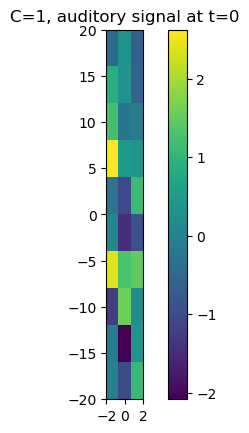

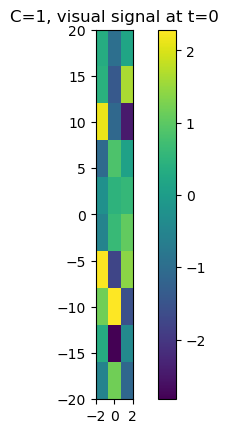

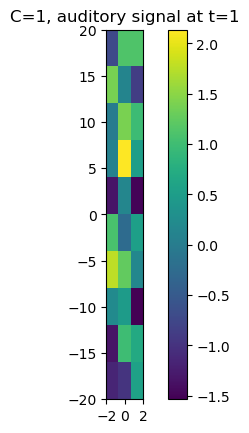

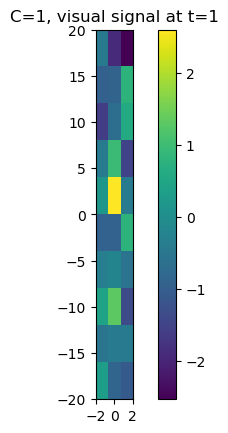

In [4]:
#variances for the caxe of C=1
sig_ls=2
sig_es=1
sig_ms=1.5

#variances for the caxe of C=2
sig_lvs=1
sig_las=5 
sig_mas=1
sig_mvs=2
sig_eas=1
sig_evs=1

#variances for the x variables, these are the same for either C=1 or C=2, but can also use different values
sig_lax=10
sig_lvx=2
sig_eax=1
sig_evx=1
sig_max=1
sig_mvx=5
p_c=0.5; #the prior probability of either one or two sources
p_h=1;

#specifying the grid
lrange=20
mrange=2
# n_lm=6
n=10 #the number of steps into which the l-space is discretised
m_n=3 #the number of steps into which the m-space is discretised
n_c=3 #the number of steps into which the c-space is discretised
l=np.linspace(-lrange,lrange,n)
m=np.linspace(-mrange,mrange,m_n)

#specifying the gain of the linear function, the maximum time, the starting point of the random walk, and the number of repeats
k=1
t_max=2
n_r=1
mean_rw=5
diff_mean=3;
c_l=np.linspace(mean_rw-diff_mean,mean_rw+diff_mean,n_c);

#Running C=1
[a_x,v_x,c_avs]=gen_mod_C1(k,t_max,l,m,n_r,mean_rw,sig_ls,sig_lax,sig_lvx,sig_ms,sig_max,sig_mvx,sig_es,sig_eax,sig_evx)

#plotting
for t in range(0,t_max):
    plt.figure(0+t*2)
    plt.title("C=1, auditory signal at t=" + str(t))
    plt.imshow(a_x[:,:,t],extent=[-mrange,mrange, -lrange,lrange]) #Somehow the x values of the a_x array get projected onto the y of the plot
    plt.colorbar()
    plt.figure(1+t*2)
    plt.title("C=1, visual signal at t=" + str(t))
    plt.imshow(v_x[:,:,t],extent=[-mrange,mrange, -lrange,lrange])
    plt.colorbar()

#Now C=2
# mean_rw=-10#running the case of C=2 with a distinguishable mean of the random walk, so we can see which plots are
# C=2 and which are C=1

# [a_x,v_x,c_as,c_vs]=gen_mod_C2(k,t_max,l,m,n_r,mean_rw,sig_las,sig_lvs,sig_lax,sig_lvx,sig_mas,sig_mvs,sig_max,sig_mvx,sig_eas,sig_evs,sig_eax,sig_evx)

# #plotting
# for t in range(0,t_max):
#     plt.figure(t_max+2+t*2)
#     plt.title("C=2, auditory signal at t=" + str(t))
#     plt.imshow(a_x[:,:,t],extent=[-mrange,mrange, -lrange,lrange])
#     plt.colorbar()
#     plt.figure(t_max+3+t*2)
#     plt.title("C=2, visual signal at t=" + str(t))
#     plt.imshow(v_x[:,:,t],extent=[-mrange,mrange, -lrange,lrange])
#     plt.colorbar()

In [5]:
print(np.shape(a_x))

(10, 3, 2)


## The case of a common source (C=1 in the generative model)

The prior in this case is given by:
\begin{equation}
\begin{aligned}
     P(L_{av}^{s}|C=1)= \mathcal{N}(\mu_{L},\sigma_{Ls}^{2}), P(M_{av}^{s}|C=1)= \mathcal{N}(\mu_{M},\sigma_{Ms}^{2}),\\ P(c_{av}^{s}|C=1)= \mathcal{N}(\mu_{c},\sigma_{cs}^{2})\\ 
\end{aligned}
\end{equation} 

The likelihood of the stimuli given the observations is given by:
\begin{equation}
\begin{aligned}
     \mathcal{L}(L^{s}_{av},M^{s}_{av},c^{s}_{av},C=1|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}})=P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}} | L^{s}_{av},M^{s}_{av},c^{s}_{av},C=1)
     =\\ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     dL^{xa}_{av} dM^{xa}_{av} 
     dL^{xv}_{av} dM^{xv}_{av}
     P(L^{xa}_{av} | L^{s}_{av},C=1) 
     P(M^{xa}_{av} | M^{s}_{av},C=1)  P(L^{xv}_{av} | L^{s}_{av},,C=1) 
     \\P(M^{xv}_{av} | M^{s}_{av},C=1)  P({a^{x}_{L^{xa}_{av},M^{xa}_{av}},v^{x}_{L^{xv}_{av},M^{xv}_{av}}} | L^{xa}_{av},M^{xa}_{av},c^{xa}_{av},L^{xv}_{av},M^{xv}_{av},c^{xv}_{av},C=1)=\\ 
     % \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     % dL^{x}_{a} dM^{x}_{a} 
     % dL^{x}_{v} dM^{x}_{v}
     % P(L^{x}_{a} | L^s,C=1) 
     % P(M^{x}_{a} | M^s,C=1)  P(L^{x}_{v} | L^s,C=1) 
     % P(M^{x}_{v} | M^s,C=1) \\ \prod_{l_{a}=1}^{n}\prod_{m_{a}=1}^{n_m}N (a^{x}_{L^{x}_{a},M^{x}_{a}}(l_{a},m_{a});\delta(l_{a}-L^{x}_{a})\delta(m_{a}-M^{x}_{a}) f^s_a(c^s),\sigma^2_{av})\\ \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{x}_{v},M^{x}_{v}}(l_{v},m_{v});\delta(l_{v}-L^{x}_{v})\delta(m_{v}-M^{x}_{v}) f^s_a(c^s),\sigma^2_{av})=\\
     \sum_{L^{xa}_{av}} \sum_{M^{xa}_{av}} 
     P(L^{xa}_{av} | L^s_{av},C=1) 
     P(M^{xa}_{av} | M^s_{av},C=1) \cdot \\ \prod_{l_{a}=1}^{n}\prod_{m_{a}=1}^{n_m}N (a^{x}_{L^{x}_{a},M^{x}_{a}}(l,m);\delta(l_{a}-L^{xa}_{av})\delta(m_{a}-M^{xa}_{av}) f^s_a(c^{s}_{av}(t)),\sigma^2_{av})\cdot \\ \sum_{L^{xv}_{av}} \sum_{M^{xv}_{av}} P(L^{xv}_{av} | L^s_{av},C=1) 
     P(M^{xv}_{av} | M^s_{av},C=1) \cdot \\ \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{xv}_{av},M^{xv}_{av}}(l_{v},m_{v});\delta(l_{v}-L^{xv}_{av})\delta(m_{v}-M^{xv}_{av}) f^s_a(c^s),\sigma^2_{av})
     \\
\end{aligned}
\end{equation}

Together the prior and likelihood give the posterior:
\begin{equation}
\begin{aligned}
    P({C=1|a^{x}_{L^{xa}_{av},M^{xa}_{av}},v^{x}_{L^{xv}_{av},M^{xv}_{av}}})=\\ P(C=1)\cdot \frac{\int \int \int P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}} | L^s, M^s, c^s,C=1) \cdot P(L^s|C=1) P(M^s|C=1) P(c^s|C=1)dL^s_{av}dM^s_{av}dc^s_{av}}{P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}})}\\
\end{aligned}
\end{equation}


In [6]:
prob_ax=np.zeros((n,m_n,n_c))
prob_vx=np.zeros((n,m_n,n_c))
prob_avx=np.zeros((n,m_n,n_c))
prob_ax_store=np.zeros((n,m_n))
prob_vx_store=np.zeros((n,m_n))
product_p_ax=np.zeros((n,m_n,n_c))
product_p_vx=np.zeros((n,m_n,n_c))
post_axc1=np.zeros((n,m_n,n_c))
post_vxc1=np.zeros((n,m_n,n_c))
post_avxc1=np.zeros((n,m_n,n_c))

#In this section the tripple integral will be performed. For this the different integrands are looped over.
#In the for loops below, in the inner loops the integrands of the likelihood are performed, and the outer loops are
#the tripple integral of the posterior is performed. The normalisation comes later.
for l_s_i in range(0,n): #Firstly looping over the L_s variable
    L_s = l[l_s_i]
    for m_s_i in range(0,m_n): #Then M_s
        M_s = m[m_s_i]
        prob_ax_t=np.ones((n,m_n))
        prob_vx_t=np.ones((n,m_n))  
        for c_s_i in range(0,n_c): #Then c_s
            mean_val=c_l[c_s_i];
            for l_x_i in range(0,n): #Now the integrals of the likelihood are evaluated, first looping over L_x
                L_x=l[l_x_i]
                prob_Lax=norm.pdf(L_x,L_s,sig_lax)#np.abs(norm.cdf(L_x-((2*lrange)/n),L_s,sig_lax)-norm.cdf(L_x+((2*lrange)/n),L_s,sig_lax)) #evaluating the p(L_X|L_S,C=1), note that it is discretised here
                prob_Lvx=norm.pdf(L_x,L_s,sig_lvx)#np.abs(norm.cdf(L_x-((2*lrange)/n),L_s,sig_lvx)-norm.cdf(L_x+((2*lrange)/n),L_s,sig_lvx))#norm.pdf(L_x,L_s,sig_lvx)
                for m_x_i in range(0,m_n): #looping over M_x
                    M_x=m[m_x_i]
                    prob_Max=norm.pdf(M_x,M_s,sig_max)#np.abs(norm.cdf(M_x-((2*mrange)/m_n),M_s,sig_max)-norm.cdf(M_x+((2*mrange)/m_n),M_s,sig_max))#evaluating the p(M_X|M_S,C=1)
                    prob_Mvx=norm.pdf(M_x,M_s,sig_mvx)#np.abs(norm.cdf(M_x-((2*mrange)/m_n),M_s,sig_mvx)-norm.cdf(M_x+((2*mrange)/m_n),M_s,sig_mvx))#norm.pdf(M_x,M_s,sig_mvx)
                    for l_i in range(0,n): #now the product in the likelihood, the shape of the input arrays is taken into account
                        for m_i in range(0,m_n):
                            if ((l_x_i==l_i) and (m_x_i==m_i)): #only at the real location is it evaluated wrt the mean_value of the random walk                            
                                prob_ax_t[l_i,m_i]=(norm.pdf(a_x[l_i,m_i,0],mean_val,sig_es))
                                prob_vx_t[l_i,m_i]=(norm.pdf(v_x[l_i,m_i,0],mean_val,sig_es))
                            else: #otherwise it is evaluated wrt 0, which is the mean of the noise in the input arrays
                                prob_ax_t[l_i,m_i]=(norm.pdf(a_x[l_i,m_i,0],0,sig_es))  
                                prob_vx_t[l_i,m_i]=(norm.pdf(v_x[l_i,m_i,0],0,sig_es))     
                    product_p_ax[l_x_i,m_x_i,c_s_i]=prob_Max*prob_Lax*(np.prod(np.prod(prob_ax_t[:,:],1),0)) #performing the double product, and multiplying the result with the P(L_x|L_s,C=1) and P(M_x|M_s,C=1)
                    product_p_vx[l_x_i,m_x_i,c_s_i]=prob_Mvx*prob_Lvx*(np.prod(np.prod(prob_vx_t[:,:],1),0))
            prob_ax[l_s_i,m_s_i,c_s_i]=np.sum(np.sum(product_p_ax[:,:,c_s_i],1),0)#performing the double summation
            prob_vx[l_s_i,m_s_i,c_s_i]=np.sum(np.sum(product_p_vx[:,:,c_s_i],1),0)
            prob_avx[l_s_i,m_s_i,c_s_i]=(prob_ax[l_s_i,m_s_i,c_s_i]*prob_vx[l_s_i,m_s_i,c_s_i]) #as this is C=1, we take the product between the visual and auditory probabilities to get the audiovisual
            prob_c_s=norm.pdf(mean_val,mean_rw,sig_es)
            prob_l_s=norm.pdf(L_s,0,sig_ls)
            prob_m_s=norm.pdf(M_s,0,sig_ms)
            post_axc1[l_s_i,m_s_i,c_s_i]=prob_c_s*prob_l_s*prob_m_s*prob_ax[l_s_i,m_s_i,c_s_i] #for checking the result
            post_vxc1[l_s_i,m_s_i,c_s_i]=prob_c_s*prob_l_s*prob_m_s*prob_vx[l_s_i,m_s_i,c_s_i]
            post_avxc1[l_s_i,m_s_i,c_s_i]=prob_c_s*prob_l_s*prob_m_s*prob_avx[l_s_i,m_s_i,c_s_i]#the final, not normalised, result

## The case of seperable sources (C=2 in the generative model)

The prior in this case if given by:
\begin{equation}
\begin{aligned}
     P(L_{a}^{s}|C=2)= \mathcal{N}(\mu_{La},\sigma_{Las}^{2}), P(L_{v}^{s}|C=2)= \mathcal{N}(\mu_{Lv},\sigma_{Lvs}^{2}),\\ P(M_{a}^{s}|C=2)= \mathcal{N}(\mu_{Ma},\sigma_{Mas}^{2}), P(M_{v}^{s}|C=2)= \mathcal{N}(\mu_{Mv},\sigma_{Mvs}^{2})\\ P(c_{a}^{s}|C=2)= \mathcal{N}(\mu_{c_{a}},\sigma_{cas}^{2}), P(c_{v}^{s}(t)|C=2)= \mathcal{N}(\mu_{c_{v}},\sigma_{cvs}^{2})
\end{aligned}
\end{equation} 

The Likelihood of the stimuli given the observations is given by:
\begin{equation}
\begin{aligned}
     \mathcal{L}(L^{s}_{a},M^{s}_{a},c^{s}_{a},L^{s}_{v},M^{s}_{v},c^{s}_{v},C=2|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}})=P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}} | L^{s}_{a},M^{s}_{a},c^{s}_{a},L^{s}_{v},M^{s}_{v},c^{s}_{v},C=2)
     = \\\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     dL^{x}_{a} dM^{x}_{a} 
     dL^{x}_{v} dM^{x}_{v}
     P(L^{x}_{a} | L^{s}_{a},C=2) 
     P(M^{x}_{a} | M^{s}_{a},C=2)  P(L^{x}_{v} | L^{s}_{v},C=2) 
     P(M^{x}_{v} | M^{s}_{v},C=2) \\ P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}} | L^{x}_{a},M^{x}_{a},c^{x}_{a},L^{x}_{v},M^{x}_{v},c^{x}_{v},C=2) =\\
(l_{a},m_{a});\delta(l_{a}-L^{x}_{a})\delta(m_{a}-M^{x}_{a}) f^s_a(c^s),\sigma^2_a)\\ \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{x}_{v},M^{x}_{v}}(l_{v},m_{v});\delta(l_{v}-L^{x}_{v})\delta(m_{v}-M^{x}_{v}) f^s_a(c^s),\sigma^2_v)\\
     = \sum_{L^{x}_{a}} \sum_{M^{x}_{a}} 
     P(L^{x}_{a} | L^{s}_{a},C=2) 
     P(M^{x}_{a} | M^{s}_{a},C=2)  \prod_{l_{a}=1}^{n}\prod_{m_{a}=1}^{n_m}N (a^{x}_{L^{x}_{a},M^{x}_{a}}(l,m);\delta(l_{a}-L^{x}_{a})\delta(m_{a}-M^{x}_{a}) f^s_a(c^s),\sigma^2_a)\\ \sum_{L^{x}_{v}} \sum_{M^{x}_{v}} P(L^{x}_{v} | L^{s}_{v},C=2) 
     P(M^{x}_{v} | M^{s}_{v},C=2)  \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{x}_{v},M^{x}_{v}}(l_{v},m_{v});\delta(l_{v}-L^{x}_{v})\delta(m_{v}-M^{x}_{v}) f^s_a(c^s),\sigma^2_v)
\end{aligned}
\end{equation}

Together the prior and Likelihood give the information that is needed for the posterior:
\begin{equation}
\begin{aligned}  
    P({C=2|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}})=
    \\ P(C=2)\cdot \int \int \int P({a^{x}_{L^{x}_{a},M^{x}_{a}}} | L^{s}_{a}, M^{s}_{a}, c^{s}_{a}, C=2)\cdot P( L^{s}_{a}|C=2) P(M^{s}_{a}|C=2) P(c^{s}_{a}|C=2) dL_{a}^{s} dM_{a}^{s} dc_{a}^{s} \\ \int \int \int P(v^{x}_{L^{x}_{v},M^{x}_{v}}| L^{s}_{v}, M^{s}_{v}, c^{s}_{v},C=2) P( L^{s}_{v}|C=2) P(M^{s}_{v}|C=2) P(c^{s}_{v}|C=2) dL_{v}^{s} dM_{v}^{s} dc_{v}^{s}\cdot \frac{1}{P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}})} \\
    % P({C=2|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}})= 
    % \\ \int \int \int \int \int \int P({L^{s}_{a}, M^{s}_{a}, c^{s}_{a}, L^{s}_{v}, M^{s}_{v}, c^{s}_{v},C=2|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}})dL_{v}^{s} dM_{v}^{s} dc_{v}^{s} dL_{a}^{s} dM_{a}^{s} dc_{a}^{s} 
    % \textnormal{For the case of C=1:} \\
    % P(C=1|a^{x},v^{x})\propto P(C=1) \cdot P(a^{x}|C=1)\cdot P(v^{x}|C=1)=P(C=1) \cdot \\ \int \int  P(C=1,L_{av}^{s},M_{av}^{s}|a^{x};v^{x}) \cdot 
    %  P(L_{av}^{s}|C=1) P(M_{av}^{s}|C=1) dL_{av}^{s} dM_{av}^{s} \\
    % \textnormal{For the case of C=2:} \\
    % P(C=2|a^{x},v^{x})\propto P(C=2) \cdot P(a^{x}|C=2)\cdot P(v^{x}|C=2)=P(C=2) \cdot \\ \int \int \int \int P(C=2,L_{a}^{s},M_{a}^{s},L_{v}^{s},M_{v}^{s}|a^{x};v^{x}) \cdot  P(L_{a}^{s}|C=2) \cdot P(M_{a}^{s}|C=2) \cdot  \\
    % P(v^{x}|C=2,L_{v}^{s},M_{v}^{s},c_{v}^{s}) P(L_{v}^{s}|C=2) P(M_{v}^{s}|C=2) dL_{v}^{s} dM_{v}^{s} dL_{a}^{s} dM_{a}^{s} \\
\end{aligned}
\end{equation}

The integrals that are needed to calculate the posterior cannot be solved analytically, therefore numerical methods are used.

Following the integrals given above, we can split the numerical solution for this case also into two parts. This code now takes far too long, need to optimise.

In [7]:
prob_ax_tc2=np.zeros((n,m_n))
prob_la=np.zeros(n)
prob_ma=np.zeros(m_n)
product_p_axc2=np.zeros((n,m_n,n_c))
prob_axc2=np.zeros((n,m_n,n_c))
post_axc2=np.zeros((n,m_n,n_c))
for l_s_i in range(0,n):    
    L_sa = l[l_s_i]
    for m_s_i in range(0,m_n):
        M_sa = m[m_s_i]    
        for c_s_i in range(0,n_c):    
            mean_vala=c_l[c_s_i] #c_s, a_x is observed so cannot loop over this, also should not as only integrate/take into account the c_s
            for l_x_i in range(0,n):
                L_xa=l[l_x_i];
                prob_Lax=norm.pdf(L_xa,L_sa,sig_lax)#np.abs(norm.cdf(L_xa-((2*lrange)/n),L_sa,sig_lax)-norm.cdf(L_xa+((2*lrange)/n),L_sa,sig_lax))
                for m_x_i in range(0,m_n):
                    M_xa=m[m_x_i];
                    prob_Max=norm.pdf(M_xa,M_sa,sig_max)#np.abs(norm.cdf(M_xa-((2*mrange)/m_n),M_sa,sig_max)-norm.cdf(M_xa+((2*mrange)/m_n),M_sa,sig_max))
                    for l_i in range(0,n):
                        for m_i in range(0,m_n):
                            if ((l_x_i==l_i) and (m_x_i==m_i)):
                                prob_ax_tc2[l_i,m_i]=norm.pdf(a_x[l_i,m_i,0],mean_vala,sig_eas)
                            else:
                                prob_ax_tc2[l_i,m_i]=norm.pdf(a_x[l_i,m_i,0],0,sig_eas)                                       
                    prob_ma[m_x_i]=prob_Max
                    prob_la[l_x_i]=prob_Lax
                    product_p_axc2[l_x_i,m_x_i,c_s_i]=prob_Max*prob_Lax*(np.prod(np.prod(prob_ax_tc2[:,:],1),0))   
            prob_axc2[l_s_i,m_s_i,c_s_i]=np.sum(np.sum(product_p_axc2[:,:,c_s_i],1),0)    #prob_c_s[c_s_i]*
            #the above is calculated for each combination of L^{s},M^{s},c^{s}   
            prob_c_sa=norm.pdf(mean_vala,mean_rw,sig_eas)
            prob_l_sa=norm.pdf(L_sa,0,sig_las)
            prob_m_sa=norm.pdf(M_sa,0,sig_mas)
            post_axc2[l_s_i,m_s_i,c_s_i]=prob_c_sa*prob_l_sa*prob_m_sa*prob_axc2[l_s_i,m_s_i,c_s_i]
prob_vx_tc2=np.zeros((n,m_n))
prob_lv=np.zeros(n)
prob_mv=np.zeros(m_n)
product_p_vxc2=np.zeros((n,m_n,n_c))
prob_vxc2=np.zeros((n,m_n,n_c))
post_vxc2=np.zeros((n,m_n,n_c))
for l_s_i in range(0,n):    
    L_sv = l[l_s_i]
    for m_s_i in range(0,m_n):
        M_sv = m[m_s_i]    
        for c_s_i in range(0,n_c):    
            mean_valv=c_l[c_s_i] #c_s, a_x is observed so cannot loop over this, also should not as only integrate/take into account the c_s
            for l_x_i in range(0,n):
                L_xv=l[l_x_i];
                prob_Lvx=norm.pdf(L_xv,L_sv,sig_lvx)#np.abs(norm.cdf(L_xv-((2*lrange)/n),L_sv,sig_lvx)-norm.cdf(L_xv+((2*lrange)/n),L_sv,sig_lvx))
                for m_x_i in range(0,m_n):
                    M_xv=m[m_x_i];
                    prob_Mvx=norm.pdf(M_xv,M_sv,sig_mvx)#np.abs(norm.cdf(M_xv-((2*mrange)/m_n),M_sv,sig_mvx)-norm.cdf(M_xv+((2*mrange)/m_n),M_sv,sig_mvx))
                    for l_i in range(0,n):
                        for m_i in range(0,m_n):
                            if ((l_x_i==l_i) and (m_x_i==m_i)):
                                prob_vx_tc2[l_i,m_i]=norm.pdf(v_x[l_i,m_i,0],mean_valv,sig_evs)
                            else:
                                prob_vx_tc2[l_i,m_i]=norm.pdf(v_x[l_i,m_i,0],0,sig_evs)                                       
                    prob_mv[m_x_i]=prob_Mvx
                    prob_lv[l_x_i]=prob_Lvx
                    product_p_vxc2[l_x_i,m_x_i,c_s_i]=prob_Mvx*prob_Lvx*(np.prod(np.prod(prob_vx_tc2[:,:],1),0))   
            prob_vxc2[l_s_i,m_s_i,c_s_i]=np.sum(np.sum(product_p_vxc2[:,:,c_s_i],1),0)    #prob_c_s[c_s_i]*
            #the above is calculated for each combination of L^{s},M^{s},c^{s}   
            prob_c_sv=norm.pdf(mean_valv,mean_rw,sig_evs)
            prob_l_sv=norm.pdf(L_sv,0,sig_lvs)
            prob_m_sv=norm.pdf(M_sv,0,sig_mvs)
            post_vxc2[l_s_i,m_s_i,c_s_i]=prob_c_sv*prob_l_sv*prob_m_sv*prob_vxc2[l_s_i,m_s_i,c_s_i]
            
post_avxc2=np.zeros((n,m_n,n_c,n,m_n,n_c))
#Now no dot product between the two signals, as the posterior is given for each of the 6 s-parameters
for l_a in range(0,n):
    for m_a in range(0,m_n):
        for c_a in range(0,n_c):
            for l_v in range(0,n):
                for m_v in range(0,m_n):
                    for c_v in range(0,n_c):
                        post_avxc2[l_a,m_a,c_a,l_v,m_v,c_v]=post_axc2[l_a,m_a,c_a]*post_vxc2[l_v,m_v,c_v]

Normalisation of the posteriors.

In [8]:
post_avxc1_p=post_avxc1/np.sum(np.sum(np.sum(post_avxc1)))
post_axc1_p=post_axc1/np.sum(np.sum(np.sum(post_axc1)))
post_vxc1_p=post_vxc1/np.sum(np.sum(np.sum(post_vxc1)))
post_avxc2_p=post_avxc2/np.sum(np.sum(np.sum(post_avxc2)))
post_axc2_p=post_axc2/np.sum(np.sum(np.sum(post_axc2)))
post_vxc2_p=post_vxc2/np.sum(np.sum(np.sum(post_vxc2)))

post_avxc1=p_c*(post_avxc1)
post_avxc2=(1-p_c)*post_avxc2#make use of the six dimensional array that is filled in the loops above

norm_const_C1=np.sum(np.sum(np.sum(post_avxc1)))
norm_const_C2=np.sum(np.sum(np.sum(np.sum(np.sum(np.sum(post_avxc2))))))

post_avxc1=post_avxc1/(norm_const_C1+norm_const_C2)
post_avxc2=post_avxc2/(norm_const_C1+norm_const_C2)

posterior_c1=np.sum(np.sum(np.sum(post_avxc1)))
posterior_c2=np.sum(np.sum(np.sum(np.sum(np.sum(np.sum(post_avxc2))))))
print("P(C=1)=", posterior_c1)
print("P(C=2)=", posterior_c2)

P(C=1)= 0.9992439615134545
P(C=2)= 0.0007560384865454365


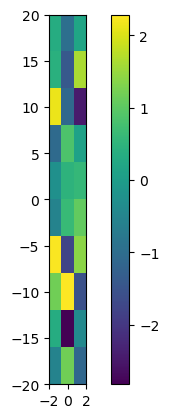

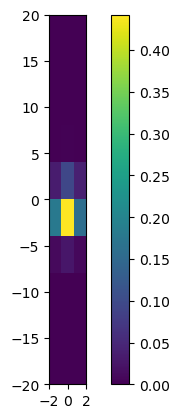

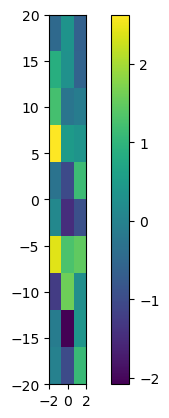

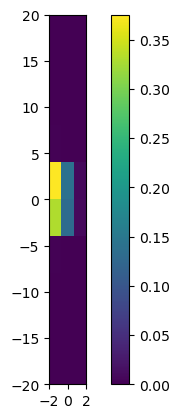

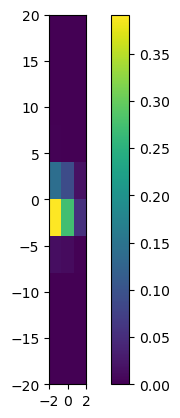

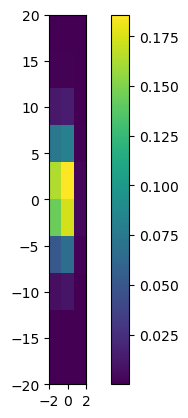

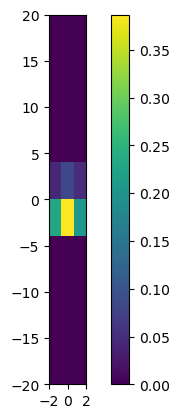

In [9]:
# plotting

plt.figure()
plt.imshow(v_x[:,:,0],extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(np.sum(post_vxc1_p,2),extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(a_x[:,:,0],extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(np.sum(post_axc1_p,2),extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(np.sum(post_avxc1_p,2),extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(np.sum(post_axc2_p,2),extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()
plt.figure()
plt.imshow(np.sum(post_vxc2_p,2),extent=[-mrange,mrange, -lrange,lrange])
plt.colorbar()

# Optimisation
The above code is way too slow, so here we should make improvements, perhaps using numpy or scipy integration methods.

The likelihood is then given by:
\begin{equation}
\begin{aligned}
     \mathcal{L}(L^{s}_{av},M^{s}_{av},c^{s}_{av},C=1|a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}})=P({a^{x}_{L^{x}_{a},M^{x}_{a}},v^{x}_{L^{x}_{v},M^{x}_{v}}} | L^{s}_{av},M^{s}_{av},c^{s}_{av},C=1)
     =\\ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     dL^{xa}_{av} dM^{xa}_{av} 
     dL^{xv}_{av} dM^{xv}_{av}
     P(L^{xa}_{av} | L^{s}_{av},C=1) 
     P(M^{xa}_{av} | M^{s}_{av},C=1)  P(L^{xv}_{av} | L^{s}_{av},,C=1) 
     \\P(M^{xv}_{av} | M^{s}_{av},C=1)  P({a^{x}_{L^{xa}_{av},M^{xa}_{av}},v^{x}_{L^{xv}_{av},M^{xv}_{av}}} | L^{xa}_{av},M^{xa}_{av},c^{xa}_{av},L^{xv}_{av},M^{xv}_{av},c^{xv}_{av},C=1)=\\ 
     % \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     % dL^{x}_{a} dM^{x}_{a} 
     % dL^{x}_{v} dM^{x}_{v}
     % P(L^{x}_{a} | L^s,C=1) 
     % P(M^{x}_{a} | M^s,C=1)  P(L^{x}_{v} | L^s,C=1) 
     % P(M^{x}_{v} | M^s,C=1) \\ \prod_{l_{a}=1}^{n}\prod_{m_{a}=1}^{n_m}N (a^{x}_{L^{x}_{a},M^{x}_{a}}(l_{a},m_{a});\delta(l_{a}-L^{x}_{a})\delta(m_{a}-M^{x}_{a}) f^s_a(c^s),\sigma^2_{av})\\ \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{x}_{v},M^{x}_{v}}(l_{v},m_{v});\delta(l_{v}-L^{x}_{v})\delta(m_{v}-M^{x}_{v}) f^s_a(c^s),\sigma^2_{av})=\\
     \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}
     dL^{xa}_{av} dM^{xa}_{av} 
     P(L^{xa}_{av} | L^s_{av},C=1) 
     P(M^{xa}_{av} | M^s_{av},C=1) \cdot \prod_{l_{a}=1}^{n}\prod_{m_{a}=1}^{n_m}N (a^{x}_{L^{x}_{a},M^{x}_{a}}(l,m);\delta(l_{a}-L^{xa}_{av})\delta(m_{a}-M^{xa}_{av}) f^s_a(c^{s}_{av}(t)),\sigma^2_{av})\cdot \\ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} dL^{xv}_{av} dM^{xv}_{av} P(L^{xv}_{av} | L^s_{av},C=1) 
     P(M^{xv}_{av} | M^s_{av},C=1) \cdot \prod_{l_{v}=1}^{n}\prod_{m_{v}=1}^{n_m} N (v^{x}_{L^{xv}_{av},M^{xv}_{av}}(l_{v},m_{v});\delta(l_{v}-L^{xv}_{av})\delta(m_{v}-M^{xv}_{av}) f^s_a(c^s),\sigma^2_{av})
     \\
\end{aligned}
\end{equation}


In [10]:
# first need to build the function that is to be integrated over
def like_C1_product_av_x(a_x,v_x,L_x,M_x,L_s,M_s,c_s,l,m):
    for l_i in range(0,n): #now the product in the likelihood, the shape of the input arrays is taken into account
        for m_i in range(0,m_n):
            if ((L_x==l[l_i]) and (M_x==m[m_i])): #only at the real location is it evaluated wrt the mean_value of the random walk                            
                prob_ax_t[l_i,m_i]=(norm.pdf(a_x[l_i,m_i,0],mean_val,sig_es))
                prob_vx_t[l_i,m_i]=(norm.pdf(v_x[l_i,m_i,0],mean_val,sig_es))
            else: #otherwise it is evaluated wrt 0, which is the mean of the noise in the input arrays
                prob_ax_t[l_i,m_i]=(norm.pdf(a_x[l_i,m_i,0],0,sig_es))  
                prob_vx_t[l_i,m_i]=(norm.pdf(v_x[l_i,m_i,0],0,sig_es))     
    product_p_ax=(np.prod(np.prod(prob_ax_t[:,:],1),0)) #performing the double product, and multiplying the result with the P(L_x|L_s,C=1) and P(M_x|M_s,C=1)
    product_p_vx=(np.prod(np.prod(prob_vx_t[:,:],1),0))
    return product_p_ax, product_p_vx
# plt.figure()
# plt.imshow(like_C1_product_av_x(a_x,v_x,1,1,1,1,1,l,m)[1])
# plt.colorbar()
print(like_C1_product_av_x(a_x,v_x,1,1,1,1,1,l,m)[0])
def like_C1_integrand(L_s,M_s,sig_l,sig_m):
    # Compute the sum of the probability density functions (PDFs) of the normal distributions
    return lambda L_x,M_x: norm.pdf(L_x, L_s, sig_l)*norm.pdf(M_x, M_s, sig_m)*like_C1_product_av_x(a_x,v_x,1,1,L_s,M_s,1,l,m)[0]

# Define the integration limits
lower_limit = -40
upper_limit = 40

# Integrate the function using quad()
result, error = integrate.dblquad(like_C1_integrand(5,3,3,3), lower_limit, upper_limit,lower_limit, upper_limit)

print("Result:", result)
print("Error:", error)

1.0951083439025078e-20
Result: 1.0793660881117586e-20
Error: 1.9918881655393814e-22


# Time varrying signals
In order to take the time varriance of the signals into account, the parameters that vary with time have to be tracked. For this the particle filter is used.

Now the particle filter for the content parameter, c (which for now is modelled as a random walk).

First for the seperable case, so we can track the auditory and visual parts seperately.

In [11]:
#setting arrays to store the important parameters
t_max=100
n_r=1 #how many times are the filters repeated, this is so that confidence intervals could be made
n_p=20 #how many particles should there be in the particle filter?

a_s=np.zeros((t_max,1)) #to be estimated
a_x=np.zeros((t_max,n_r)) #noisy observations, want one observation for each time step
phi_x=np.zeros((t_max,n)) #the samples from the distribution will be stored in here, need N samples per time step
w=np.zeros((t_max,n)) #the weights of the different particles can be stored in here, one weight for each sample
est=np.zeros((t_max,1)) #the array to store the estimates in, these will be formed by the sum over the particles, weighted by their respective weight
sig_e_s=1 #setting the variance of the random walk
sig_e_ax=1 #setting the noise in the observations


c_a_s=[np.random.randn(1)*sig_es] #drawing c_av^s from the normal distribution
for i in range(1,t_max):
    e_s=np.random.randn(1)*sig_es
    c_a_s=np.append(c_a_s, (c_a_s[i-1]+e_s)) #storing and adding noise
    f_a_s=c_a_s[i] #creating the parameter that relates the stimulus to the unnoisy/ideal percept, not necessary but might help in understanding the code
    a_s[i]=f_a_s #we now have the ideal percept, this is the latent state

for v in range(0,n_r):
    #initialising the parameters
    f_a_x=a_s[0]+np.random.randn(1)*sig_eax #creating the parameter that relates the noisy percept to the stimulus
    a_x[0,v]=f_a_x;    
    for i in range(2,t_max):
        f_a_x=c_a_s[i]+np.random.randn(1)*sig_eax #creating the parameter that relates the noisy percept to the stimulus
        a_x[i,v]=f_a_x #we now get the noisy percepts, from which we attempt to get the latent state

In [12]:
# the particle filter 
phi_x=np.zeros((t_max,n_p,n_r)); #the samples from the distribution will be stored in here (these are the particles), need N samples per time step, and n_r for each draw
w=np.zeros((t_max,n_p,n_r)); #the weights of the different particles can be stored in here, one weight for each sample
est=np.zeros((t_max,n_r)); #the array to store the estimates in, these will be formed by the sum over the particles, weighted by their respective weight
N_eff=np.zeros((t_max,n_r)); #array to store the effective sample size
# U=np.zeros((t_max,n_p,n_r)); #storing a parameter for deciding when to resample
comp_range=10000; #it seems that too large of a comparison range can drive the weights too close together and result in issues with NaN, also increases runtime a lot
rs=1.0 #parameter that defines resampling rate, 1 means always, 0 never

for v in range(0,n_r):
    #initialising the parameters
    phi_x[0,:,v]=a_x[0,v]+np.random.randn(1,n_p)*sig_es
    w_t=norm.pdf(a_x[0,v],phi_x[0,:,v],sig_eax)
    w[0,:,v]=w_t/np.sum(w_t)

    est[0,v]=np.sum(np.dot(phi_x[0,:,v],w[0,:,v]))

    for i in range(1,t_max):
        #now we have to update the samples from the distribution, and their
        #respective weights for the next time step
        phi_x[i,:,v]=phi_x[i-1,:,v]+np.random.randn(1,n_p)*sig_es
        w_t=norm.pdf(a_x[i,v],phi_x[i,:,v],sig_eax)
        w[i,:,v]=w_t/np.sum(w_t)
        est[i,v]=np.sum(np.dot(phi_x[i,:,v],w[i,:,v]))
        N_eff[i,v]=1/(np.sum(np.dot(w[i,:,v],w[i,:,v]))) #the effective weight of the samples
        if N_eff[i,v] <= (rs*n_p):
            u=np.random.uniform(0,1,n_p)
            w_sum=np.cumsum(w[i,:,v])
            w[i,:,v]=1/n_p
            for i_b in range(0,n_p): 
                for r in range(0,n_p):
                    U=((i_b-1)/n_p)+u
                    if (w_sum[r-1]<=U[r] and U[r]<w_sum[r]):
                        phi_x[i,i_b,v]=phi_x[i,r,v]

Adding Kallman filter for comparison, only possible as the random walk is fully Gaussian this will not be the case for the real model.

In [13]:
# the model is: c(i)=c(i-1)+e^{c}; a(i)=f(c(i))+e^{x}; both e^{s} and e^{x}
# are drawn from normal distributions. The notation used on the website  
# kalmanfilter.net will be used for the uncertainty (P for the c^{s}
# variance and r for the measurement uncertainty)

# initialisation, assuming the participant has proper knowledge of their
# observational noise e^{x}
P=np.zeros((t_max+1,t_max+1))
P[1,0]=1 # starting with no knowledge of the random walk, so very large variance
r=sig_eax # but with knowledge of the noise in observations
k_est=np.zeros((t_max+1,t_max+1)) # neutral starting point
k_plot=np.zeros((t_max+1,n_r))
conf_int=np.zeros((t_max+1))
# the process noise should represent the changes in the state, thus is
# given here by the speed of the random walk
nps=sig_es

# using a measurement for updating the estimate
for v in range(0,n_r):
    for i_t in range(1,t_max):
        # state update
        K=P[i_t,i_t-1]/(P[i_t,i_t-1]+r)
        k_est[i_t,i_t]=k_est[i_t,i_t-1]+K*(a_x[i_t,v]-k_est[i_t,i_t-1]) # note that the c_est array index is shifted by one due to the need for an initiliasation
        P[i_t,i_t]=(1-K)*P[i_t,i_t-1]
        # state prediction
        k_est[i_t+1,i_t]=k_est[i_t,i_t] # state extrapolation
#         conf_int[n]=np.norminv(0.95,c_plot[n+1],P[n,n]);
        P[i_t+1,i_t]=P[i_t,i_t]+sig_e_s # state extrapolation
        k_plot[i_t+1,v]=k_est[i_t,i_t]

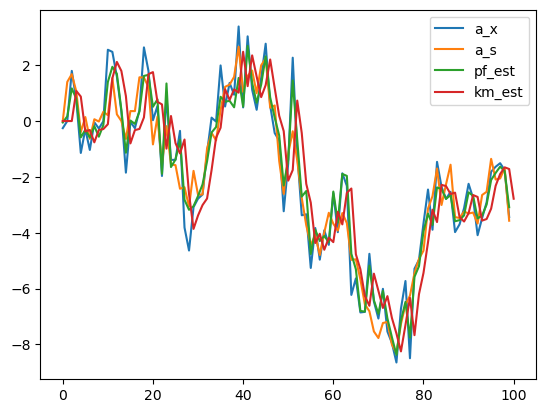

In [14]:
plt.figure()
plt.plot(np.mean(a_x,axis=1))
plt.plot(a_s)
plt.plot(np.mean(est, axis=1))
plt.plot(np.mean(k_plot,axis=1))
plt.legend(["a_x","a_s","pf_est","km_est"])

Next is a particle filter for the common source case, so there will be one audiovisual random walk that informs both the auditory and visual observations.

In [15]:
# the particle filter for C=1
#setting arrays to store the important parameters
t_max=10
n_r=1 #how many times are the filters repeated, this is so that confidence intervals could be made
n_p=50 #how many particles should there be in the particle filter?


phi_xav=np.zeros((t_max,n_p,2)) #the samples from the distribution will be stored in here, need N samples per time step
wa=np.zeros((t_max,n_p)) #the weights of the different particles can be stored in here, one weight for each sample
wv=np.zeros((t_max,n_p)) #the weights of the different particles can be stored in here, one weight for each sample
wav_t=np.zeros((t_max,n_p)) #the weights of the different particles can be stored in here, one weight for each sample
wav=np.zeros((t_max,n_p)) #the weights of the different particles can be stored in here, one weight for each sample
w_storeav=np.zeros((t_max,n_p)) #to store the before reweighting estimates
estav=np.zeros((t_max,1,2)) #the array to store the estimates in, these will be formed by the sum over the particles, weighted by their respective weight
estav_av=np.zeros((t_max))
#wv=zeros(t_max,n); %the weights of the different particles can be stored in here, one weight for each sample
#w_storev=zeros(t_max,n); %to store the before reweighting estimates
#estv=zeros(t_max,1); %the array to store the estimates in, these will be formed by the sum over the particles, weighted by their respective weight
N_eff=np.zeros((t_max,1)) #array to store the effective sample size
# U=np.zeros((t_max,n_p)) #storing a parameter for deciding when to resample
rs=1.0 #parameter that defines resampling rate, 1 means always, 0 never

[a_x,v_x,c_avs]=gen_mod_C1(k,t_max,l,m,n_r,mean_rw,sig_ls,sig_lax,sig_lvx,sig_ms,sig_max,sig_mvx,sig_es,sig_eax,sig_evx)
a_x=np.zeros((t_max,1)) #noisy auditory observations, want one observation for each time step
v_x=np.zeros((t_max,1)) #noisy visual observations, want one observation for each time step
for i in range(0,t_max):
    a_x[i]=c_avs[i]+np.random.randn(1)*sig_eax
    v_x[i]=c_avs[i]+np.random.randn(1)*sig_evx

In [16]:
#initialising the parameters
phi_xav[0,:,0]=a_x[0]+np.random.randn(1,n_p)*sig_es
phi_xav[0,:,1]=v_x[0]+np.random.randn(1,n_p)*sig_es
w_ta=norm.pdf(a_x[0],phi_xav[0,:,0],sig_eax)
wa[0,:]=w_ta/np.sum(w_ta)
w_tv=norm.pdf(v_x[0],phi_xav[0,:,1],sig_evx)
wv[0,:]=w_tv/np.sum(w_tv)

wav_t[0,:]=np.dot(wa[0,:],wv[0,:])
wav[0,:]=wav_t[0,:]/np.sum(wav_t[0,:])
# w_storeav[0,:]=wav[0,:]
# now we can obtain the particle filter estimates
# estav[0,0,0]=np.sum(np.dot(phi_xav[0,:,0],wav[0,:]))
# estav[0,0,1]=np.sum(np.dot(phi_xav[0,:,1],wav[0,:]))

estav[0,:,0]=np.sum(np.dot(phi_xav[0,:,0],wa[0,:]))
estav[0,:,1]=np.sum(np.dot(phi_xav[0,:,1],wv[0,:]))
estav_av[0]=(estav[0,0,0]+estav[0,0,1])/2

for i in range(1,t_max):
    #now we have to update the samples from the distribution, and their
    #respective weights for the next time step
    phi_xav[i,:,0]=phi_xav[i-1,:,0]+np.random.randn(1,n_p)*sig_es
    w_ta=norm.pdf(a_x[i],phi_xav[i,:,0],sig_eax)
    wa[i,:]=w_ta/np.sum(w_ta)
    estav[i,:,0]=np.sum(np.dot(phi_xav[i,:,0],wa[i,:]))
    
    phi_xav[i,:,1]=phi_xav[i-1,:,1]+np.random.randn(1,n_p)*sig_es
    w_tv=norm.pdf(v_x[i],phi_xav[i,:,1],sig_evx)
    wv[i,:]=w_tv/np.sum(w_tv)
    estav[i,:,1]=np.sum(np.dot(phi_xav[i,:,1],wv[i,:]))
    
    wav[i,:]=np.dot(np.dot(wa[i,:],wv[i,:]),wav[i-1,:])
    wav[i,:]=wav[i,:]/np.sum(wav[i,:])
    w_storeav[i,:]=wav[i,:]
    estav_av[i]=(estav[i,0,0]+estav[i,0,1])/2;
    
    N_eff[i]=1/(np.sum(np.dot(wav[i,:],wav[i,:]))) #the effective weight of the samples
    if N_eff[i,v] <= (rs*n_p):
        u=np.random.uniform(0,1,n_p)
        w_sum=np.cumsum(wav[i,:])
        wav[i,:]=1/n_p
        for s in range(0,2):
            for i_b in range(0,n_p): 
                for r in range(0,n_p):
                    U=((i_b-1)/n_p)+u
                    if (w_sum[r-1]<=U[r] and U[r]<w_sum[r]):
                        phi_xav[i,i_b,s]=phi_xav[i,r,s]

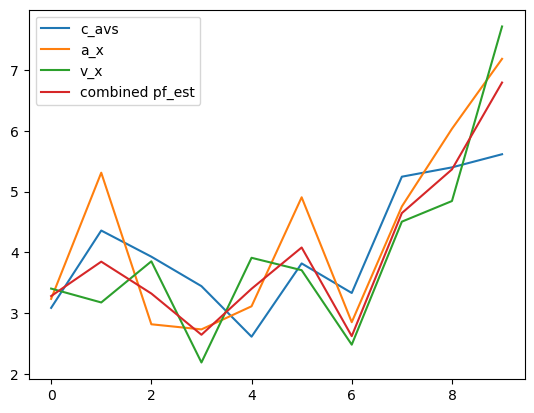

In [17]:
plt.figure()
plt.plot(c_avs)
plt.plot(a_x)
plt.plot(v_x)
plt.plot((estav_av))
# plt.plot(np.mean(phi_xav[:,:,0], axis=1))
plt.legend(["c_avs","a_x","v_x","combined pf_est"])